In [1]:
import torch
import torchvision.transforms as T
from PIL import Image
from featup.util import norm, unnorm, pca
import matplotlib.pyplot as plt
from utils.mean_shift import mean_shift_smart_init

def plot_feats(image, lr, hr):
    assert len(image.shape) == len(lr.shape) == len(hr.shape) == 3
    [lr_feats_pca, hr_feats_pca], _ = pca([lr.unsqueeze(0), hr.unsqueeze(0)], dim=9)
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    ax[0, 0].imshow(image.permute(1, 2, 0).detach().cpu())
    ax[1, 0].imshow(image.permute(1, 2, 0).detach().cpu())
    ax[2, 0].imshow(image.permute(1, 2, 0).detach().cpu())

    ax[0, 0].set_title("Image", fontsize=22)
    ax[0, 1].set_title("Original", fontsize=22)
    ax[0, 2].set_title("Upsampled Features", fontsize=22)

    ax[0, 1].imshow(lr_feats_pca[0, :3].permute(1, 2, 0).detach().cpu())
    ax[0, 0].set_ylabel("PCA Components 1-3", fontsize=22)
    ax[0, 2].imshow(hr_feats_pca[0, :3].permute(1, 2, 0).detach().cpu())

    ax[1, 1].imshow(lr_feats_pca[0, 3:6].permute(1, 2, 0).detach().cpu())
    ax[1, 0].set_ylabel("PCA Components 4-6", fontsize=22)
    ax[1, 2].imshow(hr_feats_pca[0, 3:6].permute(1, 2, 0).detach().cpu())

    ax[2, 1].imshow(lr_feats_pca[0, 6:9].permute(1, 2, 0).detach().cpu())
    ax[2, 0].set_ylabel("PCA Components 7-9", fontsize=22)
    ax[2, 2].imshow(hr_feats_pca[0, 6:9].permute(1, 2, 0).detach().cpu())

    plt.tight_layout()
    plt.close(fig)  # Close plt to avoid additional empty plots
    return fig

def clustering_features(features, num_seeds=100):
    metric = 'euclidean'
    height = features.shape[2]
    width = features.shape[3]
    out_label = torch.zeros((features.shape[0], height, width))

    # mean shift clustering
    kappa = 20
    selected_pixels = []
    for j in range(features.shape[0]):
        X = features[j].view(features.shape[1], -1)
        X = torch.transpose(X, 0, 1)
        cluster_labels, selected_indices = mean_shift_smart_init(X, kappa=kappa, num_seeds=num_seeds, max_iters=10, metric=metric)
        out_label[j] = cluster_labels.view(height, width)
        selected_pixels.append(selected_indices)
    return out_label, selected_pixels

In [2]:
input_size = 224
image_path = "D:/CODE/NIDS-Net/test_data/test_1/test_039.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_norm = True

transform = T.Compose([
    T.Resize(input_size),
    T.CenterCrop((input_size, input_size)),
    T.ToTensor(),
    norm
])

In [3]:
image_tensor = transform(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)

with torch.no_grad():
    upsampler = torch.hub.load("mhamilton723/FeatUp", 'dinov2', use_norm=use_norm).to(device)
    hr_feats = upsampler(image_tensor)

Using cache found in C:\Users\divya/.cache\torch\hub\mhamilton723_FeatUp_main
c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\featup\featurizers\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\featup\featurizers\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
c:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\featup\featurizers\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in C:\Users\divya/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\divya/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xForme

In [4]:
del upsampler
torch.cuda.empty_cache()

In [6]:
import numpy as np
w,h=np.asarray(Image.open(image_path).convert("RGB")).shape[:2]
hr_feats = torch.nn.functional.interpolate(hr_feats.detach().cpu(), (h//4,w//4), mode="bilinear") # 1, 384, H, W
hr_feats.shape

torch.Size([1, 384, 2048, 1536])

In [6]:
out_label, selected_pixels = clustering_features(hr_feats, num_seeds=100) 

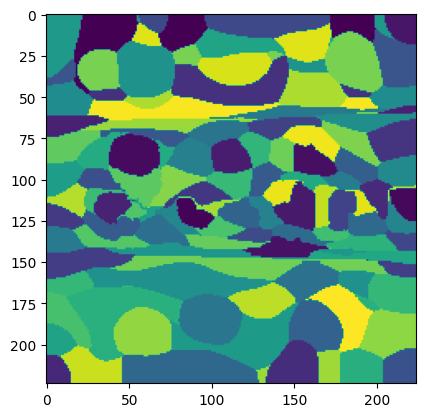

In [8]:
plt.imshow(out_label.permute(1,2,0).numpy())

(6144, 8192)